## Business Understanding
Work has already begun towards developing a COVID-19 vaccine. From measles to the common flu, vaccines have lowered the risk of illness and death, and have saved countless lives around the world. Unfortunately in some countries, the 'anti-vaxxer' movement has led to lower rates of vaccination and new outbreaks of old diseases.

Although it may be many months before we see COVID-19 vaccines available on a global scale, it is important to monitor public sentiment towards vaccinations now and especially in the future when COVID-19 vaccines are offered to the public. The anti-vaccination sentiment could pose a serious threat to the global efforts to get COVID-19 under control in the long term.

The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to vaccinations is positive, neutral, or negative. This solution could help governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs across the world.

### Project Objective.
This is a Zindi Challenge and the main objective of this project is to develop a Recurrent Neural Network to predict the Sentiment of a tweet.

### Data Source
The source of this data is from the Zindi website.

### Evaluation Metric
The evaluation metric for the project is the Root Mean Squared Error
At the end of the project, the RMSE value < 0.5

#### Import Necessary Libraries

In [1]:
# Dataframe
import pandas as pd

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Numpy
import numpy as np

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Tensorfow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils


# Keras layers
from tensorflow.keras.layers import Activation, Dense, Embedding,Dropout, Flatten, Conv1D, MaxPooling3D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# nltK

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

#Word2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# Utility
import string
import re
import os
import logging
import pickle
import datetime
import itertools
import random
from collections import Counter, defaultdict

# Wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Set Logs
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alphagoal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alphagoal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alphagoal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading averaged_perceptron_targer: Package
[nltk_data]     'averaged_perceptron_targer' not found in index
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Alphagoal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Data Understanding

In [2]:
train_df = pd.read_csv("../data/Train.csv")
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [3]:
# check shape of data
train_df.shape

(10001, 4)

Remove the neutral text

In [4]:
# Remove the neutral text
train_df = train_df[train_df['label'] != 0.0]

train_df.head()

,tweet_id,safe_text,label,agreement
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,1.0,0.666667
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",1.0,0.666667


Check for duplicates and null values

In [5]:
train_df.duplicated().sum()

0

In [6]:
train_df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

Drop Duplicates

In [7]:
train_df.dropna(axis=0, inplace=True)

In [8]:
# Confirm Changes
train_df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5091 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   5091 non-null   object 
 1   safe_text  5091 non-null   object 
 2   label      5091 non-null   float64
 3   agreement  5091 non-null   float64
dtypes: float64(2), object(2)
memory usage: 198.9+ KB


In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,5091.0,0.592222,0.805854,-1.000000,1.000000,1.0,1.0,1.0
agreement,5091.0,0.828194,0.195426,0.333333,0.666667,1.0,1.0,1.0


#### Data Preprocessing

In [11]:
# Constants Declarations
DATASET_COLUMNS = ['safe_text','label']
DATASET_ENCODING = 'ISO-8859-1'
TRAIN_SIZE = 0.8

#Parameters for Word2vec
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# keras Parameters
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# Parameters Specific to Sentiments
POSITIVE = 'POSITIVE'
NEGATIVE = 'NEGATIVE'
NEUTRAL = 'NEUTRAL'
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Parameters for Exporting Purposes
KERAS_MODEL = 'model.h5'
WORD2VEC_MODEL = 'model.w2v'
TOKENIZER_MODEL = 'tokenizer.pkl'
ENCODER_MODEL = 'encoder.pkl'

#Miscelenious
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

#### Label Encoding

In [12]:
decode_map = {-1.0 : "NEGATIVE", 1.0 : "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [13]:
train_df['label'] = train_df['label'].apply(lambda x: decode_sentiment(x))

#### Visualize Count of Labels

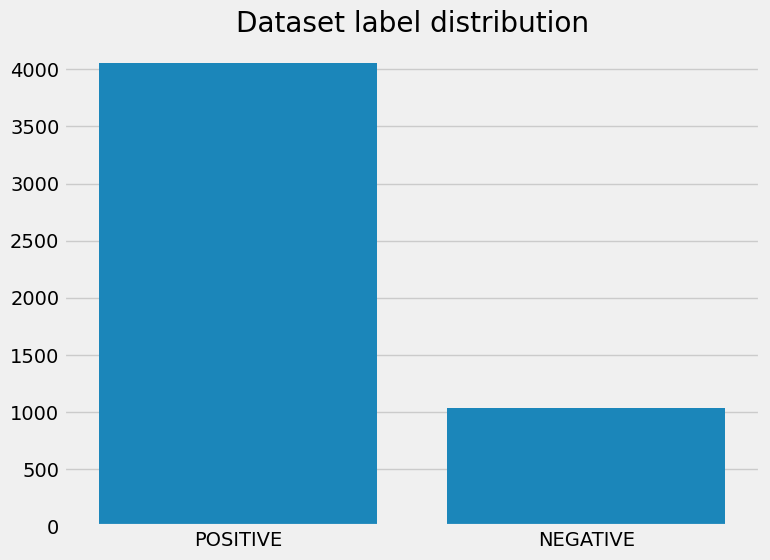

In [14]:
label_count = Counter(train_df['label'])

plt.figure(figsize=(8,6))

sns.barplot(x=label_count.keys(), y=label_count.values())
plt.title("Dataset label distribution")
plt.show()

In [15]:
train_df['safe_text'].unique()

array(["I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day",
       '#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD',
       "I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",
       ...,
       'Living in a time where the sperm I used to waste on Jenny McCarthy is doing better than some of the sperm that became kids. #vaccineswork',
       '<user> <user>  In spite of all measles outbreaks, judge in MI threatens to put father in jail if I vaccinate.',
       'Pneumonia vaccine: for women w risk of pulmonary disease, see this ACOG tweet  <url>'],
      dtype=object)

#### Text Manipulation and Structurization

In [21]:
# Including stopwords and excluding 'not' stopwords
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
more_stopwords = {'one','Unknown','br','th','fo','sayi'}

stop_words = stop_words.union(more_stopwords)
stemmer = SnowballStemmer('english')

In [16]:
# Remove urls
def remove_urls(text):
    url = re.compile(r'https?://\s+|www\.\S+')
    return url.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)

def remove_puncts(text):
    table = str.maketrans('','', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)

# Applying helper functions
train_df['mod_text'] = train_df['safe_text'].apply(lambda x: remove_urls(x))
train_df['mod_text'] = train_df['safe_text'].apply(lambda x: remove_emojis(x))
train_df['mod_text'] = train_df['safe_text'].apply(lambda x: remove_html(x))
train_df['mod_text'] = train_df['safe_text'].apply(lambda x: remove_puncts(x))
train_df['mod_text'] = train_df['safe_text'].apply(lambda x: remove_quotes(x))

In [17]:
# check cleaned text
train_df.head()

,tweet_id,safe_text,label,agreement,mod_text
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...


#### Tokenizing the Modified Text

In [18]:
train_df['tokenized'] = train_df['mod_text'].apply(word_tokenize)
train_df.head()

,tweet_id,safe_text,label,agreement,mod_text,tokenized
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...,"[Im, 100, thinking, of, devoting, my, career, ..."
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...,"[I, mean, if, they, immunize, my, kid, with, s..."
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...,"[user, a, nearly, 67, year, old, study, when, ..."
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...,"[Study, of, more, than, 95000, kids, finds, no..."


In [19]:
# lower-casing text
train_df['lower'] = train_df['tokenized'].apply(lambda x: [word.lower() for word in x])

train_df.head()

,tweet_id,safe_text,label,agreement,mod_text,tokenized,lower
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ..."
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s..."
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...,"[user, a, nearly, 67, year, old, study, when, ...","[user, a, nearly, 67, year, old, study, when, ..."
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...,"[Study, of, more, than, 95000, kids, finds, no...","[study, of, more, than, 95000, kids, finds, no..."


In [22]:
# Removing Stopwords
train_df['stopwords_removed'] = train_df['lower'].apply(lambda x: [word for word in x if word not in stop_words])

train_df.head()

,tweet_id,safe_text,label,agreement,mod_text,tokenized,lower,stopwords_removed
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,..."
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, not, vaccinate, c..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl..."
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...,"[user, a, nearly, 67, year, old, study, when, ...","[user, a, nearly, 67, year, old, study, when, ...","[user, nearly, 67, year, old, study, mental, h..."
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...,"[Study, of, more, than, 95000, kids, finds, no...","[study, of, more, than, 95000, kids, finds, no...","[study, 95000, kids, finds, link, mmr, vaccine..."


In [26]:
# Applying part of speech tags
train_df['pos_tags'] = train_df['stopwords_removed'].apply(nltk.tag.pos_tag)

train_df.head()

,tweet_id,safe_text,label,agreement,mod_text,tokenized,lower,stopwords_removed,pos_tags
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti..."
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, not, vaccinate, c...","[(whatcausesautism, NN), (vaccines, NNS), (not..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some..."
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...,"[user, a, nearly, 67, year, old, study, when, ...","[user, a, nearly, 67, year, old, study, when, ...","[user, nearly, 67, year, old, study, mental, h...","[(user, RB), (nearly, RB), (67, CD), (year, NN..."
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...,"[Study, of, more, than, 95000, kids, finds, no...","[study, of, more, than, 95000, kids, finds, no...","[study, 95000, kids, finds, link, mmr, vaccine...","[(study, NN), (95000, CD), (kids, NNS), (finds..."


In [27]:
# Get the word_net_position
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Apply to text
train_df['wordnet_tags'] = train_df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x ])

train_df.head()


,tweet_id,safe_text,label,agreement,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_tags
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti...","[(im, n), (100, n), (thinking, v), (devoting, ..."
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, not, vaccinate, c...","[(whatcausesautism, NN), (vaccines, NNS), (not...","[(whatcausesautism, n), (vaccines, n), (not, r..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some...","[(mean, a), (immunize, v), (kid, n), (somethin..."
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...,"[user, a, nearly, 67, year, old, study, when, ...","[user, a, nearly, 67, year, old, study, when, ...","[user, nearly, 67, year, old, study, mental, h...","[(user, RB), (nearly, RB), (67, CD), (year, NN...","[(user, r), (nearly, r), (67, n), (year, n), (..."
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...,"[Study, of, more, than, 95000, kids, finds, no...","[study, of, more, than, 95000, kids, finds, no...","[study, 95000, kids, finds, link, mmr, vaccine...","[(study, NN), (95000, CD), (kids, NNS), (finds...","[(study, n), (95000, n), (kids, n), (finds, v)..."


In [28]:
# Applying word lemmatizer

wnl = WordNetLemmatizer()

train_df['lemmatized'] = train_df['wordnet_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for (word, tag) in x])

train_df['lemmatized'] = train_df['lemmatized'].apply(lambda x: [word for word in x if not word in stop_words])

train_df['lemma_str'] = [' '.join(map(str,l)) for l in train_df['lemmatized']]

train_df.head()

,tweet_id,safe_text,label,agreement,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_tags,lemmatized,lemma_str
1,E3303EME,I'm 100% thinking of devoting my career to pro...,POSITIVE,1.000000,Im 100 thinking of devoting my career to provi...,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti...","[(im, n), (100, n), (thinking, v), (devoting, ...","[im, 100, think, devote, career, prove, autism...",im 100 think devote career prove autism isnt c...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",NEGATIVE,1.000000,whatcausesautism VACCINES DO NOT VACCINATE YOU...,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, not, vaccinate, c...","[(whatcausesautism, NN), (vaccines, NNS), (not...","[(whatcausesautism, n), (vaccines, n), (not, r...","[whatcausesautism, vaccine, not, vaccinate, ch...",whatcausesautism vaccine not vaccinate child
3,1DR6ROZ4,I mean if they immunize my kid with something ...,NEGATIVE,1.000000,I mean if they immunize my kid with something ...,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some...","[(mean, a), (immunize, v), (kid, n), (somethin...","[mean, immunize, kid, something, wont, secretl...",mean immunize kid something wont secretly kill...
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,POSITIVE,0.666667,user a nearly 67 year old study when mental he...,"[user, a, nearly, 67, year, old, study, when, ...","[user, a, nearly, 67, year, old, study, when, ...","[user, nearly, 67, year, old, study, mental, h...","[(user, RB), (nearly, RB), (67, CD), (year, NN...","[(user, r), (nearly, r), (67, n), (year, n), (...","[user, nearly, 67, year, old, study, mental, h...",user nearly 67 year old study mental health st...
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",POSITIVE,0.666667,Study of more than 95000 kids finds no link be...,"[Study, of, more, than, 95000, kids, finds, no...","[study, of, more, than, 95000, kids, finds, no...","[study, 95000, kids, finds, link, mmr, vaccine...","[(study, NN), (95000, CD), (kids, NNS), (finds...","[(study, n), (95000, n), (kids, n), (finds, v)...","[study, 95000, kid, find, link, mmr, vaccine, ...",study 95000 kid find link mmr vaccine autism url


In [30]:
print('Total num of rows = ', len(train_df['safe_text']))

Total num of rows =  5091


#### Feature Selection

In [33]:
# select lem_str and label features for further processing

mod_df = train_df[['lemma_str','label']]
mod_df.head()

,lemma_str,label
1,im 100 think devote career prove autism isnt c...,POSITIVE
2,whatcausesautism vaccine not vaccinate child,NEGATIVE
3,mean immunize kid something wont secretly kill...,NEGATIVE
5,user nearly 67 year old study mental health st...,POSITIVE
6,study 95000 kid find link mmr vaccine autism url,POSITIVE
